In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import urllib.request

In [2]:
class Filter:
    def __init__(self, kernel_size, kernel_type='triangle'):
        """
        Class Filter creates a filter for photo processing with following parameters:
        :param kernel_size: must be an odd number
        :param kernel_type: possible values are 'triangle', 'circle', 'inverted triangle'
        """
        assert kernel_size & 1, 'Parameter kernel_size must be an odd'
        self.kernel_size = kernel_size
        self.kernel_type = kernel_type
        self.padding = (kernel_size - 1) // 2
        self.weights = np.zeros((kernel_size, kernel_size))
        self.img_pad = None
        self.img = None
        self._create_kernel()
    
    def _create_kernel(self):
        assert self.kernel_size > 0
        height, width = self.weights.shape
        if self.kernel_type == 'triangle':
            cnt = 1
            expansion = 0
            for y in range(height):
                cnt += 1
                for x in range(width // 2 - expansion, width // 2 + expansion + 1):
                    self.weights[y][x] = 1
                
                if cnt >= 2:
                    cnt = 0
                    expansion += 1
        elif self.kernel_type == 'circle':
            def l2_distance(radius, point):
                return ((point[0] - radius)**2 + (point[1] - radius)**2)**0.5 <= radius
            
            radius = self.kernel_size // 2
            
            for y in range(height):
                for x in range(width):
                    if l2_distance(radius,(y, x)):
                        self.weights[y][x] = 1
        elif self.kernel_type == 'inverted triangle':
            cnt = 0
            expansion = self.kernel_size // 2
            for y in range(height):
                cnt += 1
                for x in range(width // 2 - expansion, width // 2 + expansion + 1):
                    self.weights[y][x] = 1
                
                if cnt >= 2:
                    cnt = 0
                    expansion -= 1
        else:
            raise Exception('Unknown type of kernel')
                    

    def _pad(self, img_like):
        padding = self.padding
        in_height, in_width, in_channels = img_like.shape
        in_height_pad = in_height + 2 * padding
        in_width_pad = in_width + 2 * padding
        
        img_pad = np.zeros((in_height_pad, in_width_pad, in_channels))
        img_pad[padding:in_height + padding, padding:in_width + padding, :] = img_like
        
        return img_pad
    
    def forward(self, img):
        """
        Takes an image 
        :param img: (an img should be an array scaled to 0...1),
        doing preprocessing (padding if it is required), filtering and 
        :return: the filtered image
        """
        self.img = img
        self.img_pad = self._pad(img)
        in_height, in_width, in_channels = self.img_pad.shape

        out_height = in_height - self.kernel_size + 1
        out_width = in_width - self.kernel_size + 1
        out_channels = in_channels
        Z = np.zeros((out_height, out_width, out_channels))
        
        kernel_size = self.kernel_size
        kernel_sum = self.weights.sum()
        
        for y in range(out_height):
            for x in range(out_width):
                for c in range(out_channels):
                    image_window = self.img_pad[y:y+kernel_size, x:x+kernel_size, c]
                    Z[y, x, c] = np.sum(image_window * self.weights) / kernel_sum
        
        assert Z.shape == self.img.shape, 'Output dimensions are not equal to input dimensions'
        return Z

In [3]:
urls = ['https://i.ytimg.com/vi/bI0WBe_8l-M/maxresdefault.jpg',
        'https://ic.pics.livejournal.com/gotskaya/15977901/237456/237456_900.jpg',
        'https://oboi-3d.ru/image/data/wallpapers/gorod-part1/M554_1.jpg', 
        'https://100oboi.ru/upload/iblock/e2d/2-A-204.jpg', 
        'https://static.mk.ru/upload/entities/2017/03/29/articles/detailPicture/ed/0b/75/9b/a7b869263bf0c8adae05019006cbe234.jpg']
for url in urls:
    urllib.request.urlretrieve(url, url.split('/')[-1])

In [4]:
import re
import os

files = [f for f in os.listdir('.') if re.match(r'.*\.jpg', f)]
files

['2-A-204.jpg',
 '237456_900.jpg',
 'a7b869263bf0c8adae05019006cbe234.jpg',
 'M554_1.jpg',
 'maxresdefault.jpg']

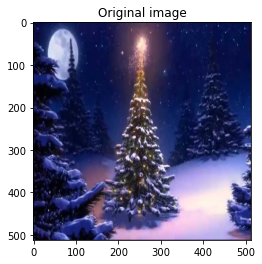

In [5]:
img = cv2.imread(files[-1])
img = cv2.resize(img, (512, 512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Original image')
plt.show()

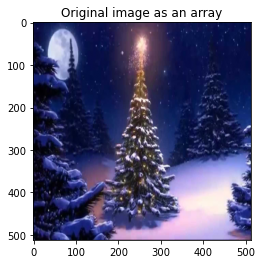

In [6]:
np_img = np.array(img, dtype='uint8')
np_img = np_img / 255
plt.imshow(np_img)
plt.title('Original image as an array')
plt.show()

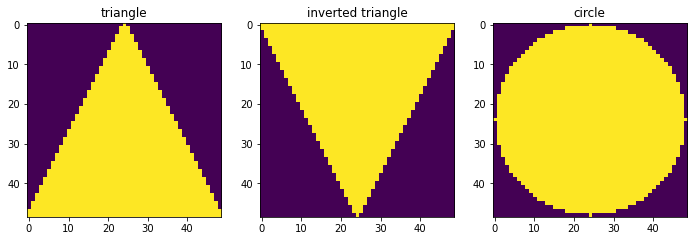

In [7]:
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 1

for i, kernel in enumerate(('triangle', 'inverted triangle', 'circle')):
    blur = Filter(kernel_size=49, kernel_type=kernel)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(blur.weights)
    plt.title(f'{kernel}')
plt.show()

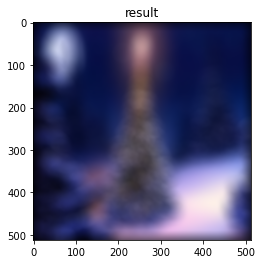

In [8]:
out_img = blur.forward(np_img)
out_img = (out_img * 255).astype('uint8')
plt.imshow(out_img)
plt.title('result')
plt.show()

In [9]:
for i, f in enumerate(files):
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512))
    np_img = np.array(img, dtype='uint8')
    np_img = np_img / 255
    result = blur.forward(np_img)
    result = (result * 255).astype('uint8')
    cv2.imwrite(f'{i}.jpg', result)

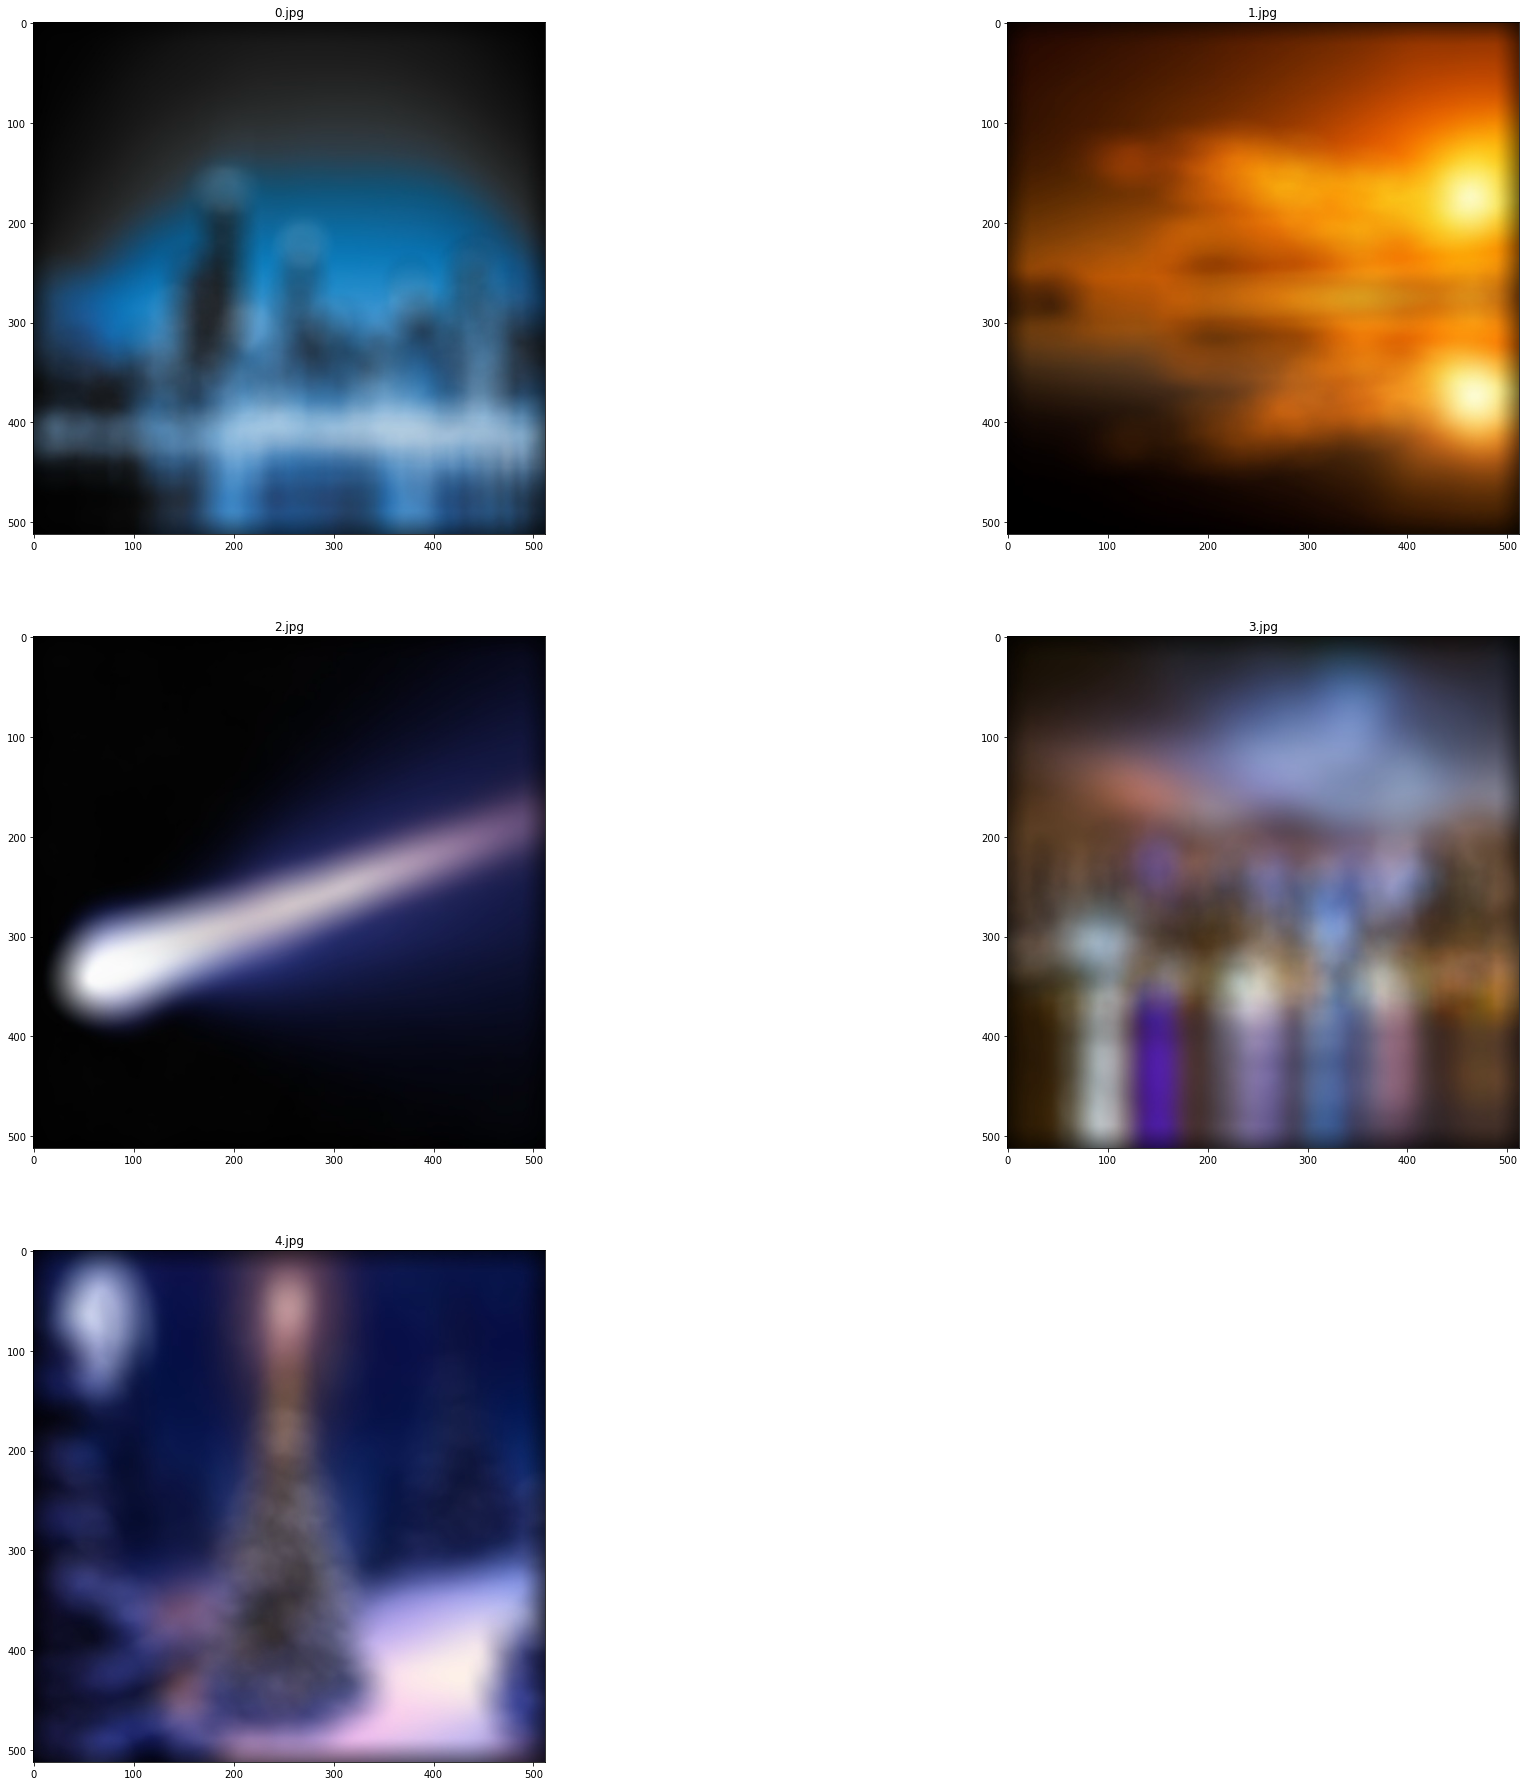

In [10]:
fig=plt.figure(figsize=(32, 32))
columns = 2
rows = 3

out_files = [f for f in os.listdir('.') if re.match(r'\d\.jpg', f)]
for i, f in enumerate(out_files):
    res = cv2.imread(f)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(res)
    plt.title(f'{f}')

plt.show()